In [4]:
import numpy as np
import pandas as pd


In [5]:
data = pd.read_csv("Rice_data.csv")

In [6]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label,soil_moisture,soil_type,...,organic_matter,irrigation_frequency,crop_density,pest_pressure,fertilizer_usage,growth_stage,urban_area_proximity,water_source_type,frost_risk,water_usage_efficiency
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,29.446064,2,...,3.121395,4,11.743910,57.607308,188.194958,1,2.719614,3,95.649985,1.193293
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,12.851183,3,...,2.142021,4,16.797101,74.736879,70.963629,1,4.714427,2,77.265694,1.752672
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,29.363913,2,...,1.474974,1,12.654395,1.034478,191.976077,1,30.431736,2,18.192168,3.035541
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,26.207732,3,...,8.393907,1,10.864360,24.091888,55.761388,3,10.861071,3,82.818720,1.273341
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,28.236236,2,...,5.202285,3,13.852910,38.811481,185.259702,2,47.190777,3,25.466499,2.578671


In [7]:
rice_data = data.drop(['label','urban_area_proximity','frost_risk'], axis =1)

In [8]:
rice_data = rice_data.rename(columns={'temperature': 'T', 'humidity': 'H', 'soil_moisture': 'Soil_M', 'soil_type':'Soil_T','sunlight_exposure': 'Sun_E','wind_speed': 'W_S', 'co2_concentration':'CO2_CONC', 'organic_matter':'Organic_M','irrigation_frequency':'Irr_F','crop_density':'Crop_D', 'pest_pressure': 'Pest_Pr','fertilizer_usage':'Fert_U','growth_stage':'Growth_St','water_source_type':'Water_S','water_usage_efficiency':'Water_U_Eff'})


In [9]:
# State : Environmental and soil conditions 
state_col = ['T','H','ph','rainfall','Soil_M','Sun_E','W_S','CO2_CONC','Crop_D','Growth_St']

# Action : Parameter for the agent to control
action_col = ['Irr_F','Fert_U']

# Reward : Efficiency 
reward_col = ['Water_U_Eff']

In [10]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

sc_state = MinMaxScaler()
sc_action = MinMaxScaler()
sc_reward = MinMaxScaler()

norm_state = sc_state.fit_transform(rice_data[state_col])
norm_action = sc_action.fit_transform(rice_data[action_col])
norm_reward = sc_reward.fit_transform(rice_data[reward_col])

# Combine normalized data into a DataFrame
norm_data = pd.DataFrame(norm_state, columns=state_col)
norm_data[action_col] = norm_action
norm_data['Water_U_Eff'] = norm_reward.flatten()

state_data = norm_data[state_col]
action_data = norm_data[action_col]

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import gym

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, state_dim=10, action_dim=2):  # Match saved model
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Use state_dim=10 to match saved model
state_dim = 10  
action_dim = 2

model = DQN(state_dim, action_dim)
model.load_state_dict(torch.load("dqn_model.pth"))
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")


Model loaded successfully!


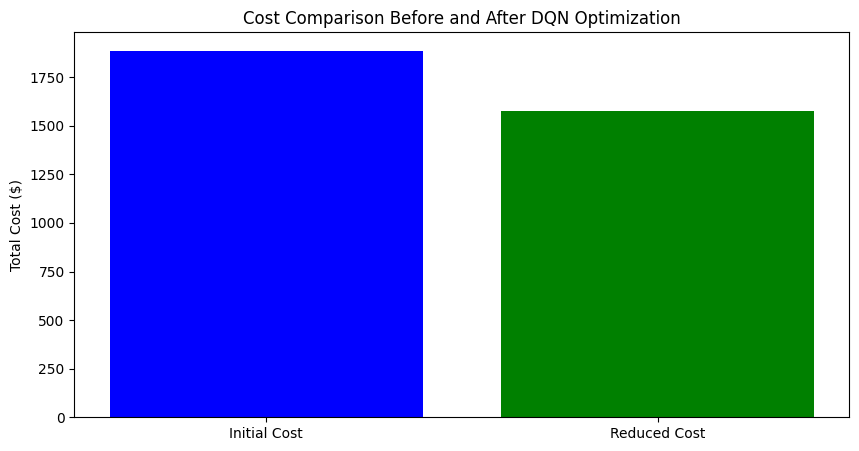

Initial Cost: $1886.53
Reduced Cost: $1575.88
Total Savings: $310.64


In [13]:
# **Cost Optimization Analysis**
water_cost_per_unit = 0.5
fertilizer_cost_per_unit = 1.2

initial_water_usage = norm_data['Irr_F']
initial_fertilizer_usage = norm_data['Fert_U']
initial_water_cost = initial_water_usage * water_cost_per_unit
initial_fertilizer_cost = initial_fertilizer_usage * fertilizer_cost_per_unit
initial_total_cost = initial_water_cost + initial_fertilizer_cost

reduced_water_usage = initial_water_usage * 0.8
reduced_fertilizer_usage = initial_fertilizer_usage * 0.85
reduced_water_cost = reduced_water_usage * water_cost_per_unit
reduced_fertilizer_cost = reduced_fertilizer_usage * fertilizer_cost_per_unit
reduced_total_cost = reduced_water_cost + reduced_fertilizer_cost

plt.figure(figsize=(10, 5))
plt.bar(['Initial Cost', 'Reduced Cost'], [initial_total_cost.sum(), reduced_total_cost.sum()], color=['blue', 'green'])
plt.title('Cost Comparison Before and After DQN Optimization')
plt.ylabel('Total Cost ($)')
plt.show()

print(f"Initial Cost: ${initial_total_cost.sum():.2f}")
print(f"Reduced Cost: ${reduced_total_cost.sum():.2f}")
print(f"Total Savings: ${initial_total_cost.sum() - reduced_total_cost.sum():.2f}")